# GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## The Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/",one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


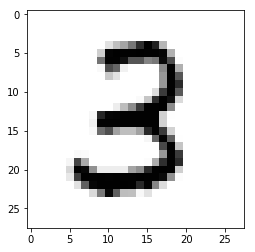

In [3]:
plt.imshow(mnist.train.images[11].reshape(28,28),cmap='Greys')

## The Generator

In [4]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output
    

## The Discriminator

In [5]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        # Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits

### Placeholders

In [6]:
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

### Generator

In [7]:
G = generator(z)

### Discriminator 

In [8]:
D_output_real , D_logits_real = discriminator(real_images)

In [9]:
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

### Losses

In [10]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))

In [11]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real)* (0.99))

In [12]:
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

In [13]:
D_loss = D_real_loss + D_fake_loss

In [14]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

### Optimizers

In [15]:
learning_rate = 0.001

In [16]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['dis/dense/kernel:0', 'dis/dense/bias:0', 'dis/dense_1/kernel:0', 'dis/dense_1/bias:0', 'dis/dense_2/kernel:0', 'dis/dense_2/bias:0']
['gen/dense/kernel:0', 'gen/dense/bias:0', 'gen/dense_1/kernel:0', 'gen/dense_1/bias:0', 'gen/dense_2/kernel:0', 'gen/dense_2/bias:0']


In [17]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

## Completion code here

In [18]:
img = tf.placeholder(tf.float32, shape=(1, 784))

In [19]:
mask = np.ones(shape=[28,28], dtype=np.float32)
mask[10:18,10:18] = 0
mask = mask.reshape(1,784)

In [20]:
img_to_correct = tf.multiply(tf.reshape(img, shape=(28,28)), tf.convert_to_tensor(tf.reshape(mask, shape=(28,28))))

In [21]:
z1 = tf.Variable(initial_value = np.random.uniform(-1, 1, size=(1, 100)).astype("float32"), dtype=tf.float32)

In [22]:
G1 = generator(z1, reuse = True)

In [23]:
img_gen_masked = tf.multiply(G1, mask)

In [24]:
contextual_loss = tf.reduce_mean(tf.abs(img_gen_masked - tf.reshape(img_to_correct,shape=(1,784))))

In [25]:
perceptual_loss = (1- discriminator(G1,reuse=True)[0])
# perceptual_loss=G_loss

In [43]:
complete_loss = contextual_loss + 0.0*perceptual_loss

In [27]:
complete_loss_trainer = tf.train.AdamOptimizer(learning_rate).minimize(complete_loss, var_list=z1)

## Training Session

In [28]:
# Save a sample per epoch
samples = []
ans_z = []

In [29]:
saver = tf.train.Saver()

In [44]:
with tf.Session() as sess:
    saver.restore(sess,'../models1/500_epoch_model.ckpt')
    for i in range(1000):
        _ = sess.run(complete_loss_trainer, feed_dict = {img: mnist.train.images[91].reshape(1, 784)})
        
    ansz = sess.run(z1)
    gen_ans = sess.run(generator(z ,reuse=True),feed_dict={z: ansz})

INFO:tensorflow:Restoring parameters from ../models1/500_epoch_model.ckpt


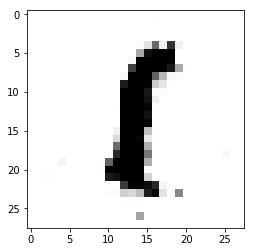

In [45]:
plt.imshow(gen_ans.reshape(28,28),cmap='Greys')